In [17]:
%pip install --q fastkaggle

Note: you may need to restart the kernel to use updated packages.


In [18]:
from fastai.vision.all import *
from fastai.imports import *
from fastkaggle import *
import torch.nn as nn

In [19]:
if iskaggle:
    path = Path("/kaggle/input/deforestationpreprocessed") / "archive"
else:
    path = Path.cwd() / "archive"

In [20]:
md_df = pd.read_csv(path / "metadata.csv")

In [21]:
md_df.head()

,image_id,split,sat_image_path,mask_path
0,100694,train,train/100694_sat.jpg,train/100694_mask.png
1,102122,train,train/102122_sat.jpg,train/102122_mask.png
2,10233,train,train/10233_sat.jpg,train/10233_mask.png
3,103665,train,train/103665_sat.jpg,train/103665_mask.png
4,103730,train,train/103730_sat.jpg,train/103730_mask.png


In [22]:
class_df = pd.read_csv(path / "class_dict.csv")
class_df.head()

,name,r,g,b
0,urban_land,0,255,255
1,agriculture_land,255,255,0
2,rangeland,255,0,255
3,forest_land,0,255,0
4,water,0,0,255


In [23]:
classes = class_df["name"].to_numpy(); classes

array(['urban_land', 'agriculture_land', 'rangeland', 'forest_land',
       'water', 'barren_land', 'unknown'], dtype=object)

In [24]:
def label_func(path):
    fname = path.name
    img_id = str(fname.split("_sat")[0])
    return path.parent / (img_id + "_mask_pre.png")

In [25]:
fnames = get_image_files(path / "train")
fnames = [fn for fn in fnames if fn.name.endswith("_sat.jpg")]
fnames[:5]

[Path('/kaggle/input/deforestationpreprocessed/archive/train/651774_sat.jpg'),
 Path('/kaggle/input/deforestationpreprocessed/archive/train/170535_sat.jpg'),
 Path('/kaggle/input/deforestationpreprocessed/archive/train/995492_sat.jpg'),
 Path('/kaggle/input/deforestationpreprocessed/archive/train/576417_sat.jpg'),
 Path('/kaggle/input/deforestationpreprocessed/archive/train/923223_sat.jpg')]

In [26]:
#quelle https://github.com/YilmazKadir/Segmentation_Losses/blob/main/losses/topk.py
from torch.nn.functional import softmax
class TopKLoss(nn.CrossEntropyLoss):
    def __init__(self, gamma=0.1):
        super().__init__(reduction='none')
        self.gamma = gamma
      
    def forward(self, input, target):
        #flatten input
        input, target = torch.flatten(input, start_dim=1), torch.flatten(target, start_dim=1)
        #get elements with highest loss
        loss = super().forward(input, target)
        loss, _ = torch.topk(loss, math.ceil(len(loss) * self.gamma))
        # return mean loss
        return loss.mean()

In [27]:
dls = SegmentationDataLoaders.from_label_func(
    path,
    bs=8,
    fnames=fnames,
    label_func=label_func,
    codes=classes,
    item_tfms=Resize(128),
    loss_func=TopKLoss()
)

In [28]:
# import torch
# import gc
# torch.cuda.empty_cache()
# gc.collect()

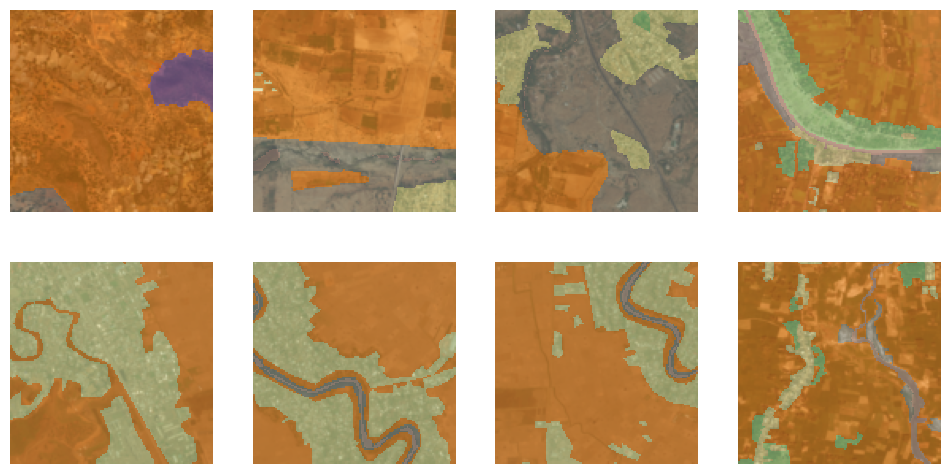

In [29]:
dls.show_batch()

In [30]:
import timm
from functools import partial
model = partial(timm.create_model, "timm/convnext_base.fb_in22k")

In [32]:
learner = unet_learner(dls, model, cbs=GradientAccumulation(4), metrics=[DiceMulti])

In [33]:
learner.fine_tune(10)

epoch,train_loss,valid_loss,dice_multi,time
0,1.485381,1.304240,0.152757,01:35


epoch,train_loss,valid_loss,dice_multi,time
0,0.927907,0.892974,0.502205,01:36
1,0.857677,0.896575,0.520355,01:38
2,0.804780,0.777957,0.531540,01:37
3,0.738764,0.698420,0.571516,01:37
4,0.676277,0.667630,0.606751,01:39
5,0.605344,0.644196,0.615514,01:39
6,0.528834,0.627351,0.648058,01:39
7,0.488918,0.612285,0.660432,01:39
8,0.438837,0.614159,0.662543,01:38
9,0.409589,0.613982,0.664651,01:39


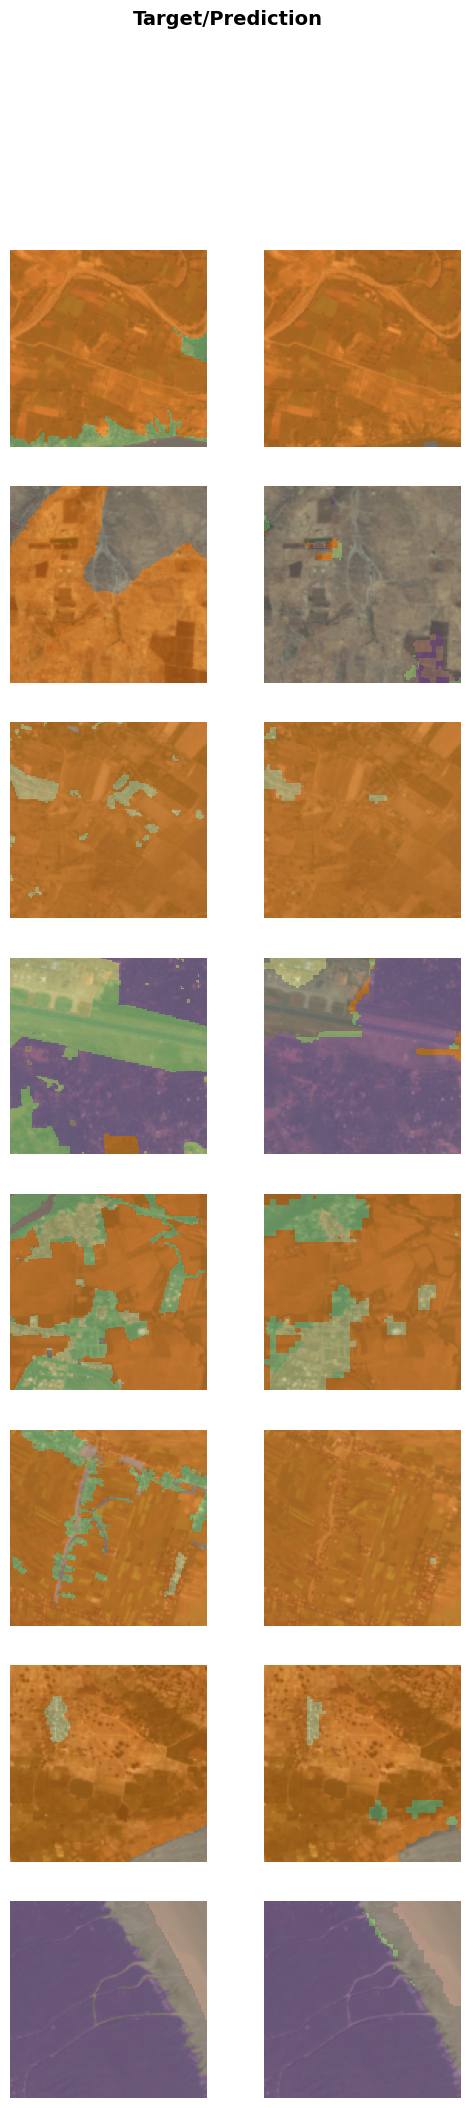

In [34]:
learner.show_results()

In [ ]:
if iskaggle:
    out_path = Path("/kaggle/working/")
else: out_path = Path.cwd()

learner.export(out_path / "unet_resnet18_128px_5e_bs4_gac.pkl")

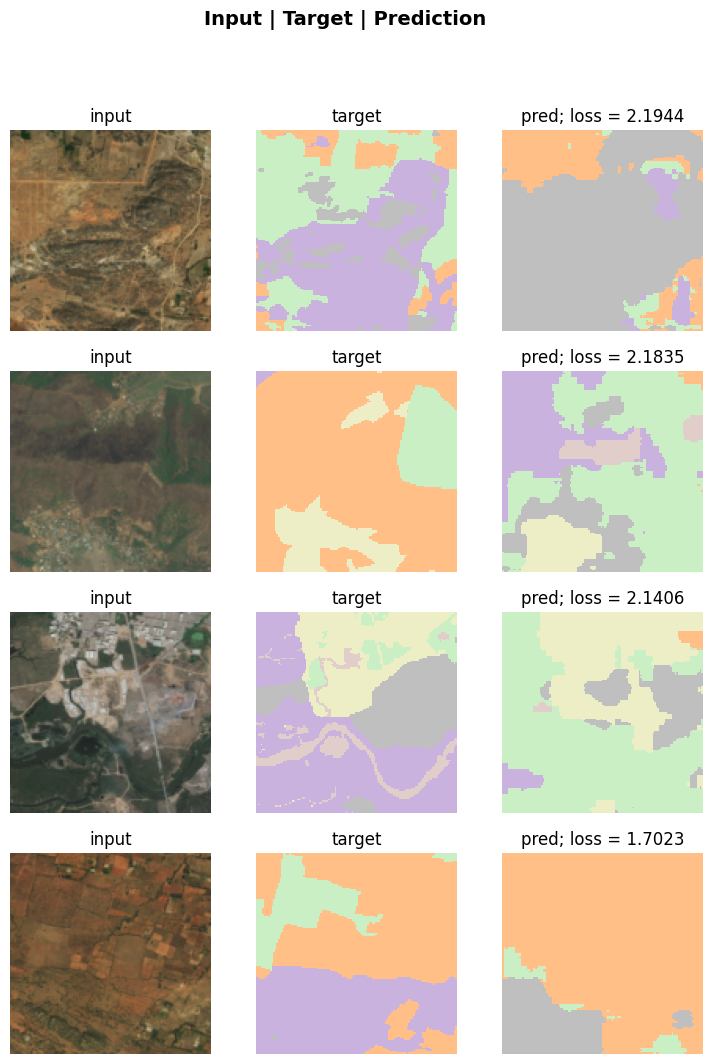

In [35]:
interp = Interpretation.from_learner(learner)
interp.plot_top_losses(4)